# Warehouse layout model

Purpose: Model a variety of warehouse layout designs, to compare their relative efficiency.

A warehouse layout is defined as a rectangular grid of cells, with each cell being a 1 metre square. The layout is defined in Excel, which uses Conditional Formatting to apply colour to each cell's shading. A cell can be one of the following types:
* b Begin (Dark red). A tour to pick items from shelves starts on this cell. There can be only one b cell.
* e End (Light red). A tour to pick items from shelves ends on this cell. The End cell should be adjacent to the Begin cell. There can be only one e cell.
* w Wall (Black). The warehouse's external walls.
* d Door (Green). There must be four Door cells (or two in small test layouts), representing two cells for an entry and two for an exit. All perimeter cells must be either a Wall or Door.
* r Rack (Dark blue). Rack cells that can enclose Shelf cells.
* s Shelf (Light blue). A shelf for storing the items to be picked. Each Shelf must be adjacent to Racks and/or Walls, with exactly one Clearway cell in a cardinal direction.
* c Clearway (Grey). Empty cells for traversing the warehouse and accessign Shelf cells.

To make a fair comparison between designs, all full layouts must have exactly 248 Shelf cells. Including the b and e cells, there are 250 cells that we need to visit. There must be adequate space between shelves, walls and the b/e cells - this means a gap of at least two metres.

To illustrate a small warehouse layout, which does not comply with all of the requirements, the following image shows b and e cells adjacent to the doors (of which there are only two cells), on the north wall. There are two columns of racks, each of which is double-sided, plus some shelves along the north wall:

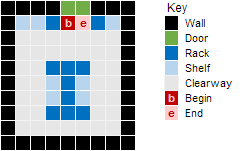

Given a layout, the model's key steps are:
* Load layout from Excel file, given filename, etc. in Globals.
* Create array of cell number labels. All cells in a design are labelled from 1 at top-left to n at bottom-right. e.g. the design above has 10 rows and 12 columns, so the first row is labelled 1 to 12 (left-to-right), the second row is labelled 13 to 24 (left-to-right), etc., with the bottom-right cell labelled 120 (= 10 * 12).
* Construct list of adjacent nodes and distances. When on a tour to pick items, a picker can walk only to adjacent Begin, End, and Clearway cells (b, e, and c). Starting with cell 1, we construct a list of adjacent b, e, and c cells that can be reached in one step from each cell. The step may be in a cardinal direction (of length 1 metre), or diagonally (of length 1.414 metres, = 2**0.5).
* Create adjacency graph. We use the adjacency list, created above, to construct a networkx directed graph object. This structure is suitable for use in various networkx functions.
* Construct mapping from every valid cell to its spot. A valid cell is all b, e, and s cells. A cell's spot is the cell where a picker would stand to access that cell. i.e. for b and e cells, the picker would stand on that b or e cell. For a Shelf s, the spot is the adjacent c cell in a cardinal direction (of which there must be only one such cell). The list of spots always has the b and e cells first, then the s cells.
* Create matrix of shortest paths between all valid cells. We use the networkx library to find the shortest path between every pair of valid cells. The path traverses the adjacency graph, taking steps from each cell to an adjacent Begin, End, or Clearway cell. We store only the length of the shortest path between each pair of cells.
* We then loop over each of the order lengths for specified number of iterations. In each iteration, we create a random list of n shelves to visit, where n is the current order length, representing a customer order of items.
* The ItemRatio parameter that creates a distribution of order probability for each item. The items are positioned on the shelves according to their probability - the most commonly ordered items are positioned closest to the Begin cell. The probabilities are created by a function, though we could use actual probabilities instead.
* The OR-Tools TSP solver produces a closed loop. However, we want our tour to start at the b cell and end at the e cell. So, to make a closed tour, we introduce a dummy node that has a very high "distance" for all cells except to b and from e (which has zero distance).
* For each order, we use OR-Tools to determine the minimum length tour around the warehouse to pick the items.
* The tour lengths are averaged for each order length and overall. We calculate a simple average of the order lengths and an average weighted by the frequency of each order length. If only a subset of the order lengths is used, then the frequency inputs are assumed to be relative (i.e. multiply by each frequency and divide by their sum).
* The efficiency of a layout is defined as the weighted average length of all tours to pick items from the shelves.
* The average tour lengths are output when the iterations are complete.

As an aside, we tried using networkx and OR-Tools for both key problems in this model: finding the shortest paths and solving the TSP. However, using the OR-Tools constraint solver to find the shortest paths is way too slow. While using networkx to do the TSP part works, the solutions are worse than the OR-Tools version (usually by only a few percent, but occasionally by a lot). Therefore, we chose the best tool for each part: we use networkx to find the shortest paths, and we use OR-Tools to solve the TSP part.

In [1]:
# Import dependencies
import networkx as nx
import pandas as pd
import numpy as np
import time as tm
import math as math
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.utils.cell import range_boundaries
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
# Globals
DesignFile = 'Layout-small.xlsx'   # Excel layout filename, assumed to be in the same folder as this model
FreqFile = 'Frequency-small.xlsx'   # Excel file containing the frequency distribution of order lengths
MinOrderItems = 1   # Minimum number of items in an order (minimum order length)
MaxOrderItems = 7   # Maximum number of items in an order (maximum order length)
NumIters = 1000   # Number of iterations for each order length. Use 1 for testing; say 1000 for final analysis
ItemRatio = 1   # Ratio of most frequently ordered item to least frequently order item. 1 = uniform distribution
DiagnosticsOn = True   # Display detailed diagnoistic data. Only set to True for small layouts, as the run time can be long and output copious
Verbose = True   # Print updates as the model proceeds

DesignWorksheet = 'Warehouse'   # Excel worksheet name containing the layout
DesignRange = 'Layout'   # Excel named range that defines the layout cells
FreqWorksheet = 'Distribution'   # Excel worksheet name with freqency data
FreqRange = 'Frequency'   # Excel named range that defines the order frequency data

IntMultiplier = 1000   # Factor to make everything integer for OR-Tools, including costs. A factor of 1000 should be sufficient

Checkpoints = []   # List of time checkpoints
Lengths = []   # Average length of TSP tour for each order length

## Timer for runtime checkpoints

Some parts of this model take a while to run. To keep track of runtime, we note the cumulative time of checkpoints by calling the Timer function with a string label, like Timer('Start');

In [3]:
# Record time checkpoints, given a label
def Timer(Point):
    Checkpoints.append([Point, tm.perf_counter()])
    if Verbose:
        print('Completed ' + Point)
    return Checkpoints

## External data files
Data for this model is stored in Excel workbooks.

We want to test many different warehouse layouts, each of which is defined in a separate file. The current design's filename is defined as a global string.

In [4]:
# Load layout from Excel file
def LoadFromExcel(ExcelFile, Worksheet, Range):
    wb = load_workbook(filename=ExcelFile, read_only=True)
    ws = wb[Worksheet]
    dests = wb.defined_names[Range].destinations
    for title, coord in dests:
        min_col, min_row, max_col, max_row = range_boundaries(coord)
        data = ws.iter_rows(min_row, max_row, min_col, max_col, values_only=True)
    ExcelData = pd.DataFrame(data)
    return ExcelData

## Preliminary data preparation
From the input data, we need to create structures that we'll use in the model. That is:
- A label for each cell of the design.
- An adjacency matrix, defining which cells are adjacent to each cell (and their distance, either 1 or 1.414).
- A graph of valid moves from each cell.
- A matrix mapping every valid cell to its spot.

In [5]:
# Create array of cell number labels.
# Cells are labelled from west-to-east and from north-to-south. i.e. top-left = 1, bottom-right = n
def ApplyLabels(rows, columns):
    currLabel = 1
    data = []
    for r in range(0, rows):
        column = []
        for c in range(0, columns):
            column.append(str(currLabel))
            currLabel += 1
        data.append(column)
    labels = pd.DataFrame(data)
    return labels

In [6]:
# Construct an edge list of adjacent nodes and distances
# When constructing a tour around the warehouse, only the c, b, and e cells can be visited
# Because each cell is 1 metre square, a step in a cardinal direction is 1m and a diagonal step is 1.414m (=2**0.5)
def ConstructAdjacency(Layout, Labels, rows, columns):
    node1 = []
    node2 = []
    weights = []
    Cardinal = 1   # Length of a step in a cardinal direction
    Diagonal = 2**0.5   # Length of a step in a diagonal direction
    edgelist = pd.DataFrame(columns=['node2', 'weights'])
    for row1 in range(0, rows):                                                    
        for column1 in range(0, columns):
            if Layout.loc[row1, column1].lower() in ('c', 'b', 'e'):
                for row2 in range(0, rows):
                    for column2 in range(0, columns):
                        if Layout.loc[row2, column2].lower() in ('c', 'b', 'e'):
                            if (abs(row2-row1) <= 1) and (abs(column2-column1) <= 1) and not(row1 == row2 and column1 == column2):   # if adjacent
                                node1.append(Labels.loc[row1, column1])
                                node2.append(Labels.loc[row2, column2])
                                if (row1 == row2) or (column1 == column2):   # Cell is in cardinal direction
                                    weights.append(Cardinal)
                                else:   # Cell is in diagonal direction
                                    weights.append(Diagonal)
    edgelist = pd.DataFrame({'node1': node1, 'node2': node2, 'weights': weights})
    return edgelist

In [7]:
# Create adjacency graph
def CreateGraph(Adjacency):
    g = nx.DiGraph()
    for i, elrow in Adjacency.iterrows():
        g.add_edge(elrow[0], elrow[1], stepsize=round(elrow[2],3))
    return g

In [8]:
# Construct mapping from every valid cell to its spot
# For cell = b/e (beginning or end), Spot = b/e
# For cell = s (shelf), Spot = adjacent cell in cardinal direction (assumed to be exactly one such cell per shelf)
def SpotMatrix(Layout, Labels, rows, columns):
    Cell = []
    Spot = []
    for row1 in range(0, rows):   # Always have b node first
        for column1 in range(0, columns):
            if Layout.loc[row1, column1].lower() == 'b':
                Cell.append(Labels.loc[row1, column1])
                Spot.append(Labels.loc[row1, column1])                
    for row1 in range(0, rows):   # Then e node
        for column1 in range(0, columns):
            if Layout.loc[row1, column1].lower() == 'e':
                Cell.append(Labels.loc[row1, column1])
                Spot.append(Labels.loc[row1, column1]) 
    for row1 in range(0, rows):   # Then each of the s nodes                 
        for column1 in range(0, columns):
            if Layout.loc[row1, column1].lower() == 's':
                coords = [(row1-1, column1),(row1,column1-1),(row1,column1+1),(row1+1,column1)]
                for row2,column2 in coords:
                    if Layout.loc[row2, column2].lower() == 'c':
                        Cell.append(Labels.loc[row1, column1])
                        Spot.append(Labels.loc[row2, column2])
    edgelist = pd.DataFrame({'Cell':  Cell, 'Spot':   Spot})
    return edgelist

## Calculate shortest path distances between cells
Create a matrix that has the length of the shortest path from every valid cell to every other valid cell.

We use the shortest_path_length function of the networkx library to do the calculation. There are a few circumstances where networkx doesn't find the shortest path, though it is always very close as far as we've seen. The effect of this discrepancy on the results is negligible.

In [9]:
# Shortest distance between two spots, using networkx
def NetworkxPath(DesignGraph, input_node, output_node):
    PathLength = nx.shortest_path_length(DesignGraph, source = input_node, target = output_node, weight = 'stepsize')
    return PathLength

In [10]:
# Create matrix of shortest paths between all spot cells
# The matrix is symmetrical, so we need to solve only one triangle and copy the result to the other triangle
def Distances(Spots, DesignGraph):
    ShortestPaths = pd.DataFrame(index=range(len(Spots)), columns=range(len(Spots)))  
    for r in range(0, len(Spots)):
        for c in range(r , len(Spots)):
            if r == c:   # Main diagonal; can't go from self to self
                ShortestPaths.at[r, c] = 0
            else:
                PathLength = NetworkxPath(DesignGraph, Spots.loc[r][1], Spots.loc[c][1])
                Decimals = round(math.log(IntMultiplier,10))
                ShortestPaths.at[r, c] = round(PathLength, Decimals)   # Upper-right triangle of matrix
                ShortestPaths.at[c, r] = round(PathLength, Decimals)   # Lower-left triangle of matrix
    return ShortestPaths

## Position the items on the shelves
There are two distinct cases:
- Items are equally likely to be positioned on any shelf. Equivalently, the item on any given shelf has a uniform probability of being picked. This is achieved by setting the global ItemRatio = 1.
- The most frequently picked items are positioned closest to the Begin cell. This is achieved by setting ItemRatio to be > 1. The larger the value of ItemRatio, the stronger the probability decline as a function of shelf distance from the Begin cell.

For example, if ItemRatio = 10, then for the test layout we have the probabilities shown in the following chart. That is:
- Probability of closest item is 0.13880
- Probability of furthest item is 0.01388
- Ratio = 10
- Sum of all probabilities = 1

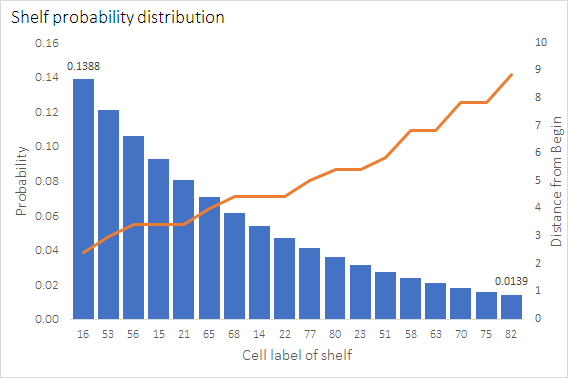

ItemRatio could be < 1 (though it must be positive), but that implies placing frequently picked items furthest from the Begin cell, which is not a practical strategy.

In [11]:
# Position items on shelves according to their order frequency. More commonly ordered items are closest to the Begin cell.
# This function creates probabilities in descending order of a cell's distance from the Begin cell, to achieve the specified ratio and have all probabilities sum to 1.
# That is, the compounding diminishing factor is defined such that Raw for closest cell is 1 and Raw for furthest cell is 1/ItemRatio.
# We then normalize the Raw values by dividing by their sum, so that we get probabilities that total 1, while preserving the probability ratio of closest to furthest cell.
def ItemsDistn(Spots, Dists):
    SpotsDistn = pd.DataFrame(Spots)
    SpotsDistn = SpotsDistn[2:]  # Slice off b and e rows. Row index then starts at 2
    SpotsDistn.insert(loc=2, column="RowNum", value=SpotsDistn.reset_index().index)
    SpotsDistn['DistanceBegin'] = Dists.iloc[:, 0]
    SpotsDistn = SpotsDistn.sort_values(by=['DistanceBegin'])
    
    d = (1/ItemRatio)**(1/(len(SpotsDistn)-1))   # Compounding diminishing factor
    Raw = []
    Raw.append(1)
    RawSum = Raw[0]
    for r in range(1, len(SpotsDistn)):
        Raw.append(Raw[r-1] * d)
        RawSum += Raw[r]
    Probability = []
    Probability.append(Raw[0] / RawSum)
    for s in range(1, len(SpotsDistn)):
        Probability.append(Raw[s] / RawSum)
    SpotsDistn['Probability'] = Probability
    SpotsDistn = SpotsDistn.sort_values(by=['RowNum'])
    return SpotsDistn

## Functions in the main loop
The core of this model is iterating over two loops (in the Main function):
- The number of items picked in each order, between a minimum and a maximum number of items. Each order length has an assumed relative frequency, though that matters only for calculating the weighted average length of all tours.
- The sample size for each number of items picked. Since we choose items randomly, we need a reasonable sample size to get good estimates of the TSP path lengths. 

In each iteration, we need to do three things:
- Create an order of specified number of items.
- Extract a subset of the shortest path matrix for the items in the current order.
- Find the length of the TSP required to pick all of the order items, from the Begin to the End cells.

In [12]:
# Create random sample of shelves, representing an order
def CreateOrder(Spots, SpotsDistn, OrderLength):
    Items = SpotsDistn.iloc[:, 0]
    Prob = SpotsDistn.iloc[:, 4]
    Position = np.random.choice(a=Items, size=OrderLength, replace=False, p=Prob)
    b = Spots.loc[0][0]
    e = Spots.loc[1][0]
    OrderList = []
    OrderList.append(b)   # Order list consists of b, e, and specified number of other cells
    OrderList.append(e)
    OrderList.extend(Position)
    return OrderList

In [13]:
# Extract shortest path matrix for current Order
def DistancesSubset(Order, Spots, Dists):
    data = []
    for d1 in range(0, len(Order)):
        for r in range(0, len(Spots)):
            if Spots.loc[r][0] == Order[d1]:
                CurrRow = []
                for d2 in range(0, len(Order)):
                    for c in range(0, len(Spots)):
                        if Spots.loc[c][0] == Order[d2]:
                            CurrRow.append(Dists[r][c])
                data.append(CurrRow)
    Subset = pd.DataFrame(data)
    return Subset

In [14]:
# Create TSP data for current order
def Create_TSP_Data(OrderDistances):
    # Create dummy node, to complete loop.
    # Penalize b --> Dummy and Dummy --> e so that we start with b and end with e.
    # i.e. TSP path is: Dummy --> b --> ... --> e --> Dummy

    TSPData = {}
    Dists = []
    for r in range(0, len(OrderDistances[0])+1):                                                    
        CurrRow = []
        for c in range(0, len(OrderDistances[1])+1):
            if r == 0:  # Dummy node
                if c <= 1:
                    CurrRow.append(0)   # Zero distance from dummy node to dummy and b nodes
                else:
                    CurrRow.append(999*IntMultiplier)   # High distance, indicating infeasible path
            else:
                if c == 0:  # Dummy node
                    if r == 0 or r == 2:
                        CurrRow.append(0)   # Zero distance from dummy and e nodes to dummy
                    else:
                        CurrRow.append(999*IntMultiplier)
                elif r == 1 and c == 2:   # b to e
                    CurrRow.append(999*IntMultiplier)   # High distance, indicating infeasible path
                else:
                    CurrRow.append(OrderDistances[r-1][c-1]*IntMultiplier)   # OR-Tools requires integer coefficients
        Dists.append(CurrRow)
    else:
        TSPData['distance_matrix'] = Dists
        TSPData['num_vehicles'] = 1
        TSPData['depot'] = 0
        return TSPData

In [15]:
# Construct output of TSP path
def TSP_solution(manager, routing, assignment):
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    plan_output += 'Route distance: {} metres\n'.format(route_distance / IntMultiplier)
    return plan_output

In [16]:
# Solve TSP for current order using OR-Tools
def DoTSP(OrderDistances):
    data = Create_TSP_Data(OrderDistances)
    manager = pywrapcp.RoutingIndexManager(    # Create the routing index manager
        len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)   # Create Routing Model.
    
    def distance_callback(from_index, to_index):   # Returns the distance between the two nodes
        from_node = manager.IndexToNode(from_index)   # Convert from routing variable Index to distance matrix NodeIndex
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)   # Define cost of each arc
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()   # Setting first solution heuristic
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    assignment = routing.SolveWithParameters(search_parameters)   # Solve the problem
    if assignment:   # Print solution on console
        rows, columns = OrderDistances.shape
        OptimalPath = TSP_solution(manager, routing, assignment)
    return assignment.ObjectiveValue(), OptimalPath

## Write outputs
We always write the model results.

Optionally, we can also:
- Write the runtime checkpoints, if the global Verbose is True.
- Output diagnostic details, including the adjacency graph, if the global DiagnosticsOn is True. Best to output diagnostics only for small test layouts.

In [17]:
# Output results
def WriteResults(Lengths, Frequency):
    print('\nSize    Length    Frequency')
    print('---------------------------')
    for i in range(0, MaxOrderItems-MinOrderItems+1):
        print(f'{MinOrderItems+i:3} {Lengths[i]:10,.2f} {Frequency[0][MinOrderItems+i-1]:12.1%}')
    print('---------------------------')
    print(f'Avg: {sum(Lengths) / len(Lengths):8,.2f}m')   # Simple average of order lengths
    SumLengths = 0
    SumWeights = 0
    for i in range(0, MaxOrderItems-MinOrderItems+1):
        SumLengths += Lengths[i] * Frequency[0][MinOrderItems+i-1]
        SumWeights += Frequency[0][MinOrderItems+i-1]
    print(f'W.Avg: {SumLengths / SumWeights:6,.2f}m\n')   # Order lengths weighted by relative order frequency

In [18]:
# Plot adjacency graph, augmented with additional information
def PlotGraph(g, Layout, Labels, rows, columns, Spots):
    currName = 0
    for r in range(1, rows+1):
        for c in range(1, columns+1):
            currName += 1
            g.add_node(str(currName), pos = (c, rows-r))
    
    pos = nx.get_node_attributes(g,'pos')
    weight = nx.get_edge_attributes(g,'stepsize')
    NodeSize = 1500
    options1 = {'edgecolors': 'black', 'node_size': NodeSize, 'alpha': 1.0}
    options2 = {'node_size': 0}
    plt.figure(figsize=(rows*1, columns*1))
    Nodes1 = []
    Nodes2 = []
    NodeColourList1 = []
    ColorDict = {'w': 'black', 'd': '#70ad47', 'b': '#c00000', 'e': '#ffcccc', 'r': '#0070c0', 's': '#b9d4ed', 'c': '#e7e6e6', 'spot': 'orange'}
    for row in range(0, rows):
        for column in range(0, columns):
            nodeColor = ColorDict[Layout.loc[row, column]]
            for CurrSpot in range(2, len(Spots)):
                if Labels.loc[row, column] == Spots.loc[CurrSpot][1]:
                    nodeColor = ColorDict['spot']
            Nodes1.append(Labels.loc[row, column])
            NodeColourList1.append(nodeColor)
            if Layout.loc[row, column].lower() == 'w':
                Nodes2.append(Labels.loc[row, column])
    nx.draw(g, pos, nodelist=Nodes1, with_labels=True, font_color='Black', font_size=18, node_color=NodeColourList1, **options1)
    nx.draw(g.subgraph(Nodes2), pos, with_labels=True, font_color='White', font_size=18, **options2)
    nx.draw_networkx_edges(g, pos, node_size=NodeSize, arrowsize=20)
    SpotConnect = nx.DiGraph()
    for i, elrow in Spots.iterrows():
        SpotConnect.add_edge(elrow[0], elrow[1])
    nx.draw_networkx_edges(SpotConnect, pos, node_size=NodeSize, arrowsize=20, width=3.0, edge_color=ColorDict['spot'])
    plt.show()

In [19]:
# Output diagnostic data, if required
def WriteDiagnostics(rows, columns, DesignGraph, Layout, Labels, Adjacency, Spots, Dists, SpotsDistn, Order, OrderDistances, TourPath):
    if DiagnosticsOn:
        PlotGraph(DesignGraph, Layout, Labels, rows, columns, Spots)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print('Layout')
            display(Layout)
            print('Labels')
            display(Labels)
            print('Adjacency')
            display(Adjacency)
            print('Spots')
            display(Spots)
            print('Distances')
            display(Dists)
            print('Spots distribution')
            display(SpotsDistn.sort_values(by=['Probability'], ascending=False))
            print('Order:', Order)
            print()
            print('OrderDistances')
            display(OrderDistances)
            print('Last path: ', TourPath)

In [20]:
# Output list of times at each checkpoint
def WriteCheckpoints():
    if Verbose:
        print('\nCheckpoint    Seconds')
        print('---------------------')
        Start = Checkpoints[0][1]
        for i in range(1, len(Checkpoints)):
            Point = Checkpoints[i][0]
            TimeStep = Checkpoints[i][1] - Start
            print(f'{Point:12}{TimeStep:9,.1f}')

## Main
Calls each of the top-level functions and controls the main sampling loop.

In [21]:
# Main program
def Main():
    Timer('Start');
    Layout = LoadFromExcel(DesignFile, DesignWorksheet, DesignRange)   # Read warehouse layout from Excel file
    Frequency = LoadFromExcel(FreqFile, FreqWorksheet, FreqRange)   # Read order items frequency from Excel file
    rows, columns = Layout.shape
    Timer('Data read');
    Labels = ApplyLabels(rows, columns)   # Apply sequenctial labels to cells of warehouse layout
    Adjacency = ConstructAdjacency(Layout, Labels, rows, columns)   # Create adjacency matrix for warehouse layout
    DesignGraph = CreateGraph(Adjacency)   # Create adjacency graph for warehouse layout
    Spots = SpotMatrix(Layout, Labels, rows, columns)   # Create list of spot cells labels for each shelf
    Timer('Preliminary');
    Dists = Distances(Spots, DesignGraph)   # Create matrix of shortest paths between all spot cells
    Timer('Distances');
    SpotsDistn = ItemsDistn(Spots, Dists)   # Position items on shelves according to their order frequency
    for OrderLen in range(MinOrderItems, MaxOrderItems+1):   # Main loop over order sizes, sampling each size NumIters times
        TotalLength = 0
        for Iter in range(1, NumIters+1):
            Order = CreateOrder(Spots, SpotsDistn, OrderLen)   # Create random sample of shelves, representing an order
            OrderDistances = DistancesSubset(Order, Spots, Dists)   # Extract shortest path matrix for current Order
            TourLength, TourPath = DoTSP(OrderDistances)   # Find optimal TSP tour for current order
            TotalLength += TourLength
            AvgLength = (TotalLength / IntMultiplier) / NumIters   # Average tour length for current order size
        Lengths.append(AvgLength)
        Timer('Size ' + str(OrderLen));
    Timer('Model finish');
    WriteResults(Lengths, Frequency)
    WriteDiagnostics(rows, columns, DesignGraph, Layout, Labels, Adjacency, Spots, Dists, SpotsDistn, Order, OrderDistances, TourPath)
    Timer('Output');
    WriteCheckpoints()

Completed Start
Completed Data read
Completed Preliminary
Completed Distances
Completed Size 1
Completed Size 2
Completed Size 3
Completed Size 4
Completed Size 5
Completed Size 6
Completed Size 7
Completed Model finish

Size    Length    Frequency
---------------------------
  1       8.91        30.0%
  2      13.67        20.0%
  3      16.62        15.0%
  4      18.79        10.0%
  5      20.20        10.0%
  6      21.09        10.0%
  7      21.48         5.0%
---------------------------
Avg:    17.25m
W.Avg:  14.98m



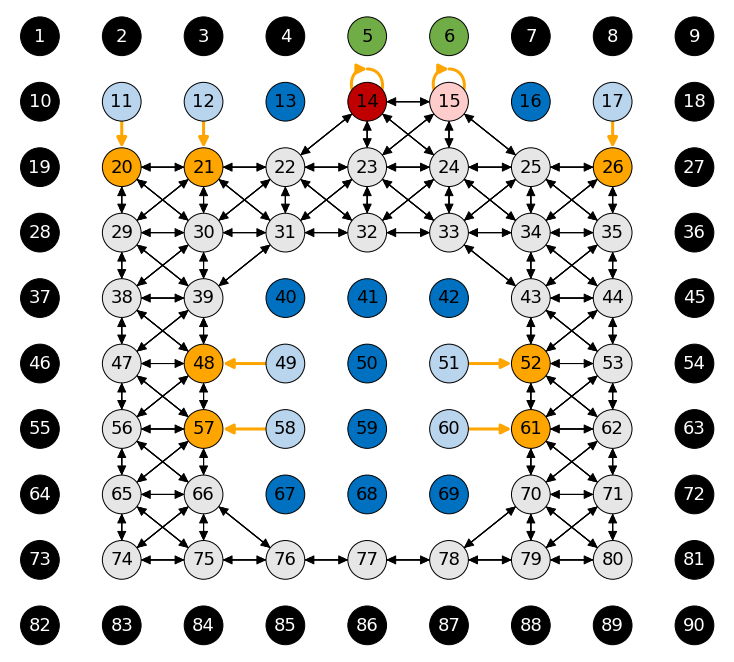

Layout


,0,1,2,3,4,5,6,7,8
0,w,w,w,w,d,d,w,w,w
1,w,s,s,r,b,e,r,s,w
2,w,c,c,c,c,c,c,c,w
3,w,c,c,c,c,c,c,c,w
4,w,c,c,r,r,r,c,c,w
5,w,c,c,s,r,s,c,c,w
6,w,c,c,s,r,s,c,c,w
7,w,c,c,r,r,r,c,c,w
8,w,c,c,c,c,c,c,c,w
9,w,w,w,w,w,w,w,w,w


Labels


,0,1,2,3,4,5,6,7,8
0,1,2,3,4,5,6,7,8,9
1,10,11,12,13,14,15,16,17,18
2,19,20,21,22,23,24,25,26,27
3,28,29,30,31,32,33,34,35,36
4,37,38,39,40,41,42,43,44,45
5,46,47,48,49,50,51,52,53,54
6,55,56,57,58,59,60,61,62,63
7,64,65,66,67,68,69,70,71,72
8,73,74,75,76,77,78,79,80,81
9,82,83,84,85,86,87,88,89,90


Adjacency


,node1,node2,weights
0,14,15,1.000000
1,14,22,1.414214
2,14,23,1.000000
3,14,24,1.414214
4,15,14,1.000000
5,15,23,1.414214
6,15,24,1.000000
7,15,25,1.414214
8,20,21,1.000000
9,20,29,1.000000


Spots


,Cell,Spot
0,14,14
1,15,15
2,11,20
3,12,21
4,17,26
5,49,48
6,51,52
7,58,57
8,60,61


Distances


,0,1,2,3,4,5,6,7,8
0,0,1.0,3.414,2.414,3.414,4.828,4.828,5.828,5.828
1,1.0,0,4.414,3.414,2.414,5.242,4.414,6.242,5.414
2,3.414,4.414,0,1.0,6.0,3.414,6.828,4.414,7.828
3,2.414,3.414,1.0,0,5.0,3.0,5.828,4.0,6.828
4,3.414,2.414,6.0,5.0,0,6.828,3.414,7.828,4.414
5,4.828,5.242,3.414,3.0,6.828,0,6.828,1.0,7.828
6,4.828,4.414,6.828,5.828,3.414,6.828,0,7.828,1.0
7,5.828,6.242,4.414,4.0,7.828,1.0,7.828,0,6.828
8,5.828,5.414,7.828,6.828,4.414,7.828,1.0,6.828,0


Spots distribution


,Cell,Spot,RowNum,DistanceBegin,Probability
2,11,20,0,3.414,0.142857
3,12,21,1,2.414,0.142857
4,17,26,2,3.414,0.142857
5,49,48,3,4.828,0.142857
6,51,52,4,4.828,0.142857
7,58,57,5,5.828,0.142857
8,60,61,6,5.828,0.142857


Order: ['14', '15', '12', '58', '11', '51', '17', '60', '49']

OrderDistances


,0,1,2,3,4,5,6,7,8
0,0.000,1.000,2.414,5.828,3.414,4.828,3.414,5.828,4.828
1,1.000,0.000,3.414,6.242,4.414,4.414,2.414,5.414,5.242
2,2.414,3.414,0.000,4.000,1.000,5.828,5.000,6.828,3.000
3,5.828,6.242,4.000,0.000,4.414,7.828,7.828,6.828,1.000
4,3.414,4.414,1.000,4.414,0.000,6.828,6.000,7.828,3.414
5,4.828,4.414,5.828,7.828,6.828,0.000,3.414,1.000,6.828
6,3.414,2.414,5.000,7.828,6.000,3.414,0.000,4.414,6.828
7,5.828,5.414,6.828,6.828,7.828,1.000,4.414,0.000,7.828
8,4.828,5.242,3.000,1.000,3.414,6.828,6.828,7.828,0.000


Last path:  Route for vehicle 0:
 0 -> 1 -> 3 -> 5 -> 9 -> 4 -> 8 -> 6 -> 7 -> 2 -> 0
Route distance: 21.484 metres

Completed Output

Checkpoint    Seconds
---------------------
Data read         0.0
Preliminary       0.1
Distances         0.1
Size 1            8.0
Size 2           21.7
Size 3           40.7
Size 4           63.7
Size 5           92.8
Size 6          130.4
Size 7          178.3
Model finish    178.3
Output          182.3


In [22]:
Main()